In [94]:
from scipy.interpolate import interp1d

import numpy as np
import scipy as s
import csv as c
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt
import itertools
import pickle

import Parameters as prms
import APPIREDII_Cytokines_Parser as cyto
import APPIREDII_Blood_Params_Parser as dp

from matplotlib import cm
# from tqdm import tqdm

"""
Code to model the innate immune response coupled with the Alkaline Phosphatase simulator.
Created on Thu Mar 10 11:24:36 2016. Runtime is in minutes.
"""

__author__ = "Louella Alva Presbitero"


sns.set_palette("deep")
sns.set_color_codes("deep")


def vectorfield(w, t, p, params):
    """
    Define differential equations for the innate immune system.

    Arguments:
        w : vector of the state variables
            w=[N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH,
            N_A, ND_A, ACH, ND_N]
        t : time
        p : vector of the parameters
    """

    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMblood, ITMtissue, M_R, M_A, CH, N_A, ND_A, \
    ACH, ND_N = pre_vectorfield(w, params)

    mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN, mu_NR, mu_ITM, \
    Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA, \
    theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, \
    beta_CHMA, beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, \
    Pmax_APE, Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, \
    step_max, r_NDN, r_ITM, ITMblood_peak, r_AP, rinduce, ITM_source_peak, ITM_source_width, add_ITMblood = p
    
    ### Add ITMs for CT
    # start at 48 hours
    
#     print (t/60., sum_added_ITMs)
    t_add = 48. * 60.
    sum_added_ITMs = add_ITMblood * 1. / (1. + np.exp(t_add - t))

    if t >= t_add + 3*60.:
        sum_added_ITMs = 0
    
    ###

    hypothesis = 0
    CH_delay = 20
    NDA_delay = 5. * 60.
    delay_AP = 60.

    f_dillution = 1./16. # (80/5) ratio betweenblood tissue compartment and blood compartment

    t_ITM = 10.
    t_ITM_source = 5. * 60.
    t_inject = 8. * 60.

    if params['h'] == 'h4':
        hypothesis = (rinduce_peak / (1 + np.exp(rinduce*(t - delay_AP)))) * (AP_Sblood + AP_Stissue)

    hypothesis *= int(not (hypothesis < 0))

    if params['restrict']:
        source_ITM = ITM_source_peak * np.exp(-(1. / (2. * (ITM_source_width ** 2))) * (t - t_ITM_source) ** 2)
    else:
        source_ITM = 0

    f = [
        # N_R
        - mu_NR * N_R
        - (Pmax_NR * (CH / (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R
        + (r_Nhomeo * (1. - N_R / Nmax) * N_R) * (int(not (N_R < 0)))
        ,

        # AP_Eblood
        - mu_APE * AP_Eblood
        - lamb_APE * AP_Eblood * ITMblood
        - ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood
        + (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2))) * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Etissue
        - mu_APE * AP_Etissue
        - lamb_APE * AP_Etissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Eblood,

        # AP_Eliver
        (1. / (1. + np.exp(- r_AP * (t - delay_AP)))) *
        (hypothesis + rdistress * np.exp(-(1. / (2. * (w_gauss_min ** 2))) * (AP_Eblood + AP_Sblood) ** 2)),

        # AP_Sblood
        (- mu_APS * AP_Sblood
         - lamb_APS * AP_Sblood * ITMblood
         + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
         - ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Sblood)
        * (int(not (AP_Sblood < 0))),

        # AP_Stissue
        - mu_APS * AP_Stissue
        - lamb_APS * AP_Stissue * ITMtissue
        + f_dillution * ((Pmax_APE - Pmin_APE) * (CH / (CH + Keq_CH)) + Pmin_APE) * AP_Sblood,

        # ITMblood
        (- mu_ITM * ITMblood
         - ITMblood * (lamb_APE * AP_Eblood + lamb_APS * AP_Sblood)
         - ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood * (1 - ITMtissue / ITMmax))
        * (int(not (ITMblood < 0)))
        + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))
        + source_ITM
        + sum_added_ITMs,

        # ITMtissue
        (- mu_ITM * ITMtissue
         - ITMtissue * (
             lamb_APE * AP_Etissue
             + lamb_APS * AP_Stissue
             + lamb_ITMMA * M_A
             + lamb_ITMNDN * N_A)
         + alpha_ITMNDN * ND_N
         + f_dillution * ((Pmax_ITM - Pmin_ITM) * (CH / (CH + Keq_CH)) + Pmin_ITM) * ITMblood
         * (1. - ITMtissue / ITMmax)) * (int(not (ITMtissue < 0))),

        # M_R
        - mu_MR * M_R - (phi_MRA * M_R * ITMtissue / (1 + theta_ACH * ACH))
        + (((Pmax_MR - Pmin_MR) * (CH / (CH + Keq_CH)) + Pmin_MR) * (Mmax - (M_A + M_R))),

        # M_A
        - mu_MA * M_A + (phi_MRA * M_R * ITMtissue) / (1 + theta_ACH * ACH),

        # CH
        (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
        (-mu_CH * CH
         + ((beta_CHNA * N_A * ITMtissue
             + beta_CHMA * M_A * ITMtissue) * (1 - CH / CHmax_tissue) / (1 + theta_ACH * ACH))),

        # N_A
        - mu_NDA * (N_A / (1 + ITMtissue))
        - (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (lamb_ITMNDN * (ITMtissue * N_A))
        + f_dillution * ((Pmax_NR) * (CH / (CH + Keq_CH))) * (1 - N_A / Nmax) * N_R,

        # ND_A
        mu_NDA * (N_A / (1 + ITMtissue)) - lamb_MANDA * M_A * ND_A,

        # ACH
        (- mu_ACH * ACH + (alpha_ACHMA * M_A + beta_MANDA * M_A * ND_A) * (1 - ACH / ACHmax)),

        # ND_N
        (1. / (1. + np.exp(- r_NDN * (t - NDA_delay)))) * (
        lamb_ITMNDN * (ITMtissue * N_A) - lamb_MANDN * M_A * ND_N)
    ]
    return post_vectorfield(f, w, params)


In [95]:
def to_min(t):
    set_t = set_time(t, time)
    if time == 'sec':
        return set_t / 60
    elif time == 'min':
        return t
    elif time == 'hours':
        return t * 60
    elif time == 'days':
        return t * 1440


def pre_vectorfield(w, params):
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = w
    if params['case'] == 0:
        N_R = AP_Eblood = AP_Etissue, AP_Eliver = AP_Sblood = AP_Stissue = M_R = M_A = CH = N_A = ND_A = ACH = ND_N = 0
    elif params['case'] == 1:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = CH = ACH = 0
    elif params['case'] == 2:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 3:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4:
        AP_Eblood = AP_Etissue = AP_Eliver = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 4.5:
        AP_Eblood = AP_Etissue = AP_Sblood = AP_Stissue = 0
    elif params['case'] == 5:
        AP_Sblood = AP_Stissue  = 0
    return [N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N]


def post_vectorfield(f, w, params):
    _w = place_finder(w)
    N_R, AP_Eblood, AP_Etissue, AP_Eliver, AP_Sblood, AP_Stissue, ITMb, ITM, M_R, M_A, CH, N_A, ND_A, ACH, ND_N = _w
    if params['case'] == 0:
        f[N_R] = f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] \
            = f[ITMb] = f[ITM] = f[M_R] = f[M_A] = f[CH] = f[N_A] = f[ND_A] = f[ACH] = f[ND_N] = 0
    elif params['case'] == 1:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = f[CH] = f[ACH] = 0
    elif params['case'] == 2:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 3:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 4:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Eliver] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 4.5:
        f[AP_Eblood] = f[AP_Etissue] = f[AP_Sblood] = f[AP_Stissue] = 0
    elif params['case'] == 5:
        f[AP_Sblood] = f[AP_Stissue] = 0
    return f


def place_finder(w):
    _w = []
    for i in range(len(w)):
        _w.append(i)
    return _w

In [96]:
def solve(p, w0, t, params):
    """
    Solves the coupled ordinary differential equations and prints it.

    Arguments:
        p        :  vector of the parameters
        w0       :  vector of the initial conditions
        filename :  name of file to store solution
        t        :  time step
        prnt     :  True/False
    """

    # ODE solver parameters
    abserr = 1.0e-8
    relerr = 1.0e-6

    # Create the time samples for the output of the ODE solver.
    wsol = s.integrate.odeint(vectorfield, w0, t,
                              args=(p, params),
                              atol=abserr,
                              rtol=relerr,
                              mxstep=100000)
    return t, wsol


def get_init(w0, params):
    """
    Sets the initial conditions based on the assigned case.

    Arguments:
        w0       :  vector of the initial conditions
    """
    N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0 = w0

    if params['case'] == 0:
        N_R0 = AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = M_R0 = M_A0 = CH0 = N_A0 = ND_A0 = ACH0 = ND_N0 = 0
    elif params['case'] == 1:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = CH0 = ACH0 = 0
    elif params['case'] == 2:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 3:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4:
        AP_Eb0 = AP_Et0 = AP_El0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 4.5:
        AP_Eb0 = AP_Et0 = AP_S0 = AP_St0 = 0
    elif params['case'] == 5:
        AP_S0 = AP_St0 = 0
    w0 = [N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMb0, ITM0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0]
    return w0

In [97]:
def read_data(csvfilename):
    x, y = [], []
    with open(csvfilename + '.csv') as csvfile:
        reader = c.DictReader(csvfile)
        for row in reader:
            x.append(float(row['time']))
            y.append(float(row['concentration']))
    return x, y


def interpolate_data(csvfilename, num, plot, time, _stoptime):
    x, y = read_data(csvfilename)
    if time == 'sec':
        x_ = np.linspace(0, _stoptime / 3600., num=num, endpoint=True)
    elif time == 'min':
        x_ = np.linspace(0, _stoptime / 60., num=num, endpoint=True)
    elif time == 'hours':
        x_ = np.linspace(0, _stoptime / 1., num=num, endpoint=True)
    elif time == 'days':
        x_ = np.linspace(0, _stoptime * 24, num=num, endpoint=True)
    f = interp1d(x, y)
    if plot:
        return np.linspace(0, _stoptime, num), f(x_)
    else:
        return f(x_)


def convert_to_day(not_day, time):
    if time == 'sec':
        return not_day / 86400.
    elif time == 'min':
        return not_day / 1440.
    elif time == 'hours':
        return not_day / 24.
    elif time == 'days':
        return not_day / 1.


def set_time(t, time, timeout):
    tlist = []
    for i in t:
        if timeout == 'days':
            if time == 'sec':
                i = i * 86400
            elif time == 'min':
                i = i * 1440
            elif time == 'hours':
                i = i * 24
            elif time == 'days':
                i = i * 1
        elif timeout ==  'hours':
            i = i / 60
        tlist.append(i)
    return tlist


def convert_organ_conc(C, organ):
    """
    :param C: Total AP concentration
    :param organ: either blood or tissue
    :return: returns IU/mm^3
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
        return C * d /80.
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
        return C * d /5.
        # return C * d / (5. * 1e6)


def convert_AP(C, APtype, organ):
    """
    Converts the concentration of Alkaline Phosphatase from IU to mm^3/L. We assume that C refers to the entire
    concentration C in the body, which shall further be divided by 80 kg.

    ref: http://www.physiologyweb.com/calculators/units_per_volume_solution_concentration_calculator.html
    C=Ax(m/v) where C=U/L and A=U/mg. Therefore m/v = (U/L)/(U/mg) which gives mg/L
    In order to convert mg/L to cells/mm^3, I can convert mg to moles (by using the molecular mass of
    Alkaline Phosphatase which is roughly 160kDa), then finally to "cells". Liter is easily converted to mm^3.

    returns: cells/mm^3
    """
    C = convert_organ_conc(C, organ)
    if APtype == 'supp': A = 2000.
    elif APtype == 'endo': A = 1000.
    return (C * 6.02 * 10 ** 23) / (160e12*A)


def reverse_organ_conc(C, organ):
    """
    :param C: AP in IU/mm^3
    :param organ:
    :return: AP in IU/L, this is under the assumption that one needs to display the concentrations based on a /L
             basis
    """
    if organ == 'tissue':
        d = 1.0599  # g/cm^3
    elif organ == 'blood':
        d = 1.0428  # g/cm^3
    return C/d


def reverse_AP(C, APtype, organ):
    """
    :param C: AP in cells/mm^3 that is already divided by 80 kg
    :param APtype:
    :param organ:
    :return: AP in IU
    """
    if APtype == 'supp':
        A = 2000
    elif APtype == 'endo':
        A = 1000
    return reverse_organ_conc(C * 160e12 * A / (6.02 * 10 ** 23), organ)


def limit(x, y, start, end):
    _x = []
    _y = []
    for i in range(len(x)):
        if x[i] >= start and x[i] <= end:
            _x.append(x[i])
            _y.append(y[i])
    return _x, _y

In [98]:
def loop_fig(fignum):
    return fignum + 1


def get_header():
    header = ['N_R', 'AP_Eblood', 'AP_Etissue', 'AP_Eliver', 'AP_Sblood', 'AP_Stissue', 'ITMblood', 'ITMtissue',
              'M_R', 'M_A', 'CH', 'N_A', 'ND_A', 'ACH', 'ND_N']
    return header


def plot(wsol, df_AP_median, case_names, timein, t_interval, df_IL6, df_IL10, params, case):
    """
    Plots the solution of the coupled ordinary differential equations.
    """

    sns.set_style("ticks")
    sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": 2.5})
    df_AP_placebo_median = df_AP_median[df_AP_median['treatment'] == 'Placebo']
    df_AP_supplemented_median = df_AP_median[df_AP_median['treatment'] == 'bIAP']

    lw = 5
    ls = 20
    fs = 25
    lfs = 25
    ts = 30

    timeout = 'hours'
    t = set_time(t_interval, timein, timeout)

    df_model = pd.DataFrame(wsol)
    keys = df_model.columns.values
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    case_label = case_names[params['case']-1]

    df_CH_plc = df_IL6[df_IL6['treatment'] == 'placebo']
    df_CH_biap = df_IL6[df_IL6['treatment'] == 'biap']

    df_ACH_plc = df_IL10[df_IL10['treatment'] == 'placebo']
    df_ACH_biap = df_IL10[df_IL10['treatment'] == 'biap']

    if case_label == 'Placebo':
        color = "#377eb8"
    else:
        color = "#4daf4a"

    if case >= 1:
        n = loop_fig(5)
        plt.figure(n)
        plt.plot(t, df_model['N_A'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        plt.savefig('result/plots/' + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_N'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        plt.savefig('result/plots/' + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['ND_A'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
        plt.ylim((0, 25))
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        plt.savefig('result/plots/' + 'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, df_model['N_R'], linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        plt.savefig('result/plots/' + 'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['M_A']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        plt.savefig('result/plots/' + 'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, np.log10(df_model['M_R']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Resting Macrophages')
        plt.savefig('result/plots/' + 'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (np.log10(df_model['ITMtissue'])), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        plt.savefig('result/plots/' + 'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, (df_model['ITMblood']), linewidth=lw, label=case_label, ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(loc='best', fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        plt.savefig('result/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            plt.figure(0)
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'Placebo':
                plt.errorbar(x=list(df_CH_plc['time']), y=list(df_CH_plc['median']), yerr=list(df_CH_plc['mad']),
                                 alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0,prms._stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(loc='best', fontsize=lfs)
            plt.xlim((0, prms._stoptime / 60.))
            print('... Plotting Data for IL6')
            plt.savefig('result/plots/' + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(1)
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'Placebo':
                plt.errorbar(list(df_ACH_plc['time']), list(df_ACH_plc['median']), yerr = list(df_ACH_plc['mad']),
                                 alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, prms._stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.legend(loc='best', fontsize=15)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            plt.savefig('result/plots/' + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if case_label != 'Placebo':
            plt.figure(3)
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'bIAP':
                plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
                                 yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
                                 label='Data Median', ms=15)
            plt.xlim((0,prms._stoptime/60.))
            plt.ylim((0, 5*10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL6')
            plt.savefig('result/plots/' + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            plt.figure(4)
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label="Model", ls='-', color="#377eb8")
            if case_label == 'bIAP':
                plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
                                 alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, prms._stoptime/60.))
            plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            plt.savefig('result/plots/' + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n)
            plt.errorbar(x=list(df_AP_placebo_median['time']),
                             y=list(df_AP_placebo_median['median']),
                             yerr=list(df_AP_placebo_median['mad']),
                             alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.plot((t), reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'), '-', linewidth=lw,
                         label='Model', color="#377eb8")
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase", fontsize=ts)
            plt.xlim((0, prms._stoptime/60.))
            plt.ylim((0, 150))
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Placebo Experiment')
            try:
                plt.savefig('result/plots/placebo.png', dpi=300, bbox_inches='tight')
            except:
                os.makedirs('result')
                plt.savefig('result/plots/placebo.png', dpi=300, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Etissue'],'endo','tissue'), linewidth=lw, label=case_label,
                     ls='-', color = color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.tick_params(labelsize=ls)
        plt.legend(fontsize=lfs)
        plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        plt.savefig('result/plots/' + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 6:
        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Sblood'], 'supp', 'blood') , linewidth=lw, label=case_label,
                     ls='-', color=color)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        plt.savefig('result/plots/' + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.plot(t, reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'), linewidth=lw, label=case_label,
                     ls='-', color = color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        plt.savefig('result/plots/' + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n)
        plt.errorbar(x=list(df_AP_supplemented_median['time']),
                         y=list(df_AP_supplemented_median['median']),
                         yerr=list(df_AP_supplemented_median['mad']),
                         alpha=.5,
                         marker='o',
                         color='#e41a1c',
                         label='Data Median',
                         ms=15)
        plt.plot(t, reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') + reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), '-',
                     linewidth=lw,
                     label='Model',
                     color="#377eb8")
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0, prms._stoptime / 60.))
        plt.ylim((0, 800))
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')
        try:
            plt.savefig('result/plots/bIAP.png', dpi=300, bbox_inches='tight')
        except:
            os.makedirs('result')
            plt.savefig('result/plots/bIAP.png', dpi=300, bbox_inches='tight')


In [99]:
def plot_ITMs(directory, wsol, df_AP_median, case_names, timein, t_interval, df_IL6, df_IL10,
         params, ITMtissue0, color, marker, alpha, case):
    """
    Plots the solution of the coupled ordinary differential equations.
    """
    plt.rc('text', usetex=True)
    plt.rc('font', family='serif')

    # sns.set_style("ticks")
    # sns.set_style({"xtick.direction": "in", "ytick.direction": "in", "axes.linewidth": 2.5})
    df_AP_placebo_median = df_AP_median[df_AP_median['treatment'] == 'Placebo']
    df_AP_supplemented_median = df_AP_median[df_AP_median['treatment'] == 'bIAP']

    lw = 0.5
    ls = 20
    fs = 25
    lfs = 15
    ts = 25
    ms = 10

    timeout = 'hours'
    t = set_time(t_interval, timein, timeout)

    df_model = pd.DataFrame(wsol)
    keys = df_model.columns.values
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    case_label = case_names[params['case']-1]

    df_CH_plc = df_IL6[df_IL6['treatment'] == 'placebo']
    df_CH_biap = df_IL6[df_IL6['treatment'] == 'biap']

    df_ACH_plc = df_IL10[df_IL10['treatment'] == 'placebo']
    df_ACH_biap = df_IL10[df_IL10['treatment'] == 'biap']

    # if case_label == 'Placebo':
    #     color = "#377eb8"
    # else:
    #     color = "#4daf4a"

    if not os.path.exists(directory + 'result/plots/'):
        os.makedirs(directory + 'result/plots/')

    skip_num = 200

    df_model = skip_data_points_df(df_model, skip_num)
    t = skip_data_points(t, skip_num)
    if case >= 1:
        n = 0
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, df_model['N_A'], linewidth=lw,
                 label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker,
                 markerfacecolor='none', ms=ms)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Neutrophils", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Neutrophils')
        plt.savefig(directory + 'result/plots/' + 'Activated_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, df_model['ND_N'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-',
                 color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Necrotic Neutrophils", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Necrotic Neutrophils')
        plt.savefig(directory + 'result/plots/' + 'Necrotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, df_model['BM'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-',
                 color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(IU/L$)", fontsize=fs)
        plt.title("Alkaline Phosphatase from Liver", fontsize=ts)
        # plt.ylim((0, 25))
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Alkaline Phosphatase from Liver')
        plt.savefig(directory + 'result/plots/' + 'AP_Liver.png', format='png', dpi=500,
                    bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, df_model['ND_A'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Apoptotic Neutrophils", fontsize=ts)
        # plt.ylim((0, 25))
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)

        print('... Plotting Apoptotic Neutrophils')
        plt.savefig(directory + 'result/plots/' + 'Apoptotic_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, df_model['N_R'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Mature Resting Neutrophils", fontsize=ts)
        plt.ylim((0, Nmax))
        plt.tick_params(labelsize=ls)
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        print('... Plotting Resting Neutrophils')
        plt.savefig(directory + 'result/plots/' + 'Resting_Neutrophils.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, (df_model['M_A']), linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Activated Macrophages", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        print('... Plotting Activated Macrophages')
        plt.savefig(directory + 'result/plots/' + 'Activated_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        # plt.plot(t, np.log10(df_model['M_R']), linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color)
        plt.plot(t, df_model['M_R'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-',
                 color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        # plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.title("Resting Macrophages", fontsize=ts)
        plt.legend(fontsize=lfs)
        # plt.ylim((0, Mmax))
        plt.ylim((0, 0.005))

        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Resting Macrophages')
        plt.savefig(directory + 'result/plots/' + 'Resting_Macrophages.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, (np.log10(df_model['ITMtissue'])), linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        plt.xlim((0, prms._stoptime / 60.))
        # plt.axvline(x=54, color='yellow')

        # plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.title("ITM in Tissue", fontsize=ts)
        print('... Plotting ITMs in Tissue')
        plt.savefig(directory + 'result/plots/' + 'ITMS_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0: plt.grid()
        plt.plot(t, np.log10(df_model['ITMblood']), linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        # plt.axvline(x=55, color='yellow')
        plt.ylabel("$log_{10}$ Concentration $(cells/mm^3$)", fontsize=fs)
        # plt.ylabel("Concentration $(cells/mm^3$)", fontsize=fs)
        plt.legend(fontsize=lfs)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.title("Plasma ITM", fontsize=ts)
        print('... Plotting ITMs in Plasma')
        plt.savefig(directory + 'result/plots/' + 'ITMS_Plasma.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 2:
        if case_label != 'bIAP':
            n = loop_fig(n)
            plt.figure(n, figsize=(8, 6))
            if alpha == 1.0 : plt.grid()
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
            # if case_label == 'Placebo':
            #     plt.errorbar(x=list(df_CH_plc['time']), y=list(df_CH_plc['median']), yerr=list(df_CH_plc['mad']),
            #                      alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0,prms._stoptime/60.))
            # plt.ylim((0, 5 * 10 ** 7))
            # plt.axvline(x=55, color='yellow')
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            plt.xlim((0, prms._stoptime / 60.))
            print('... Plotting Data for IL6')
            plt.savefig(directory + 'result/plots/' + 'Placebo_IL6.png', format='png', dpi=500, bbox_inches='tight')

            n = loop_fig(n)
            plt.figure(n, figsize=(8, 6))
            if alpha == 1.0 : plt.grid()
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
            # if case_label == 'Placebo':
            #     plt.errorbar(list(df_ACH_plc['time']), list(df_ACH_plc['median']), yerr = list(df_ACH_plc['mad']),
            #                      alpha=.5, linewidth=1.5, marker='o',color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, prms._stoptime/60.))
            # plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            plt.savefig(directory + 'result/plots/' + 'Placebo_IL10.png', format='png', dpi=500, bbox_inches='tight')

        if ITMtissue0 != 'Placebo':
            n = loop_fig(n)
            plt.figure(n, figsize=(8, 6))
            if alpha == 1.0 : plt.grid()
            plt.plot(df_model['Time'], df_model['CH'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
            # if case_label == 'bIAP':
            #     plt.errorbar(x=list(df_CH_biap['time']), y=list(df_CH_biap['median']),
            #                      yerr=list(df_CH_biap['mad']), alpha=.5, marker='o', color='#e41a1c',
            #                      label='Data Median', ms=15)
            plt.xlim((0,prms._stoptime/60.))
            # plt.ylim((0, 5*10**7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Pro-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL6')
            plt.savefig(directory + 'result/plots/' + 'bIAP_IL6.png', format='png', dpi=500, bbox_inches='tight')

            n = loop_fig(n)
            plt.figure(n, figsize=(8, 6))
            if alpha == 1.0: plt.grid()
            plt.plot(df_model['Time'], df_model['ACH'], linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
            # if case_label == 'bIAP':
            #     plt.errorbar(x=list(df_ACH_biap['time']), y=list(df_ACH_biap['median']), yerr=list(df_ACH_biap['mad']),
            #                      alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.xlim((0, prms._stoptime/60.))
            # plt.ylim((0, 5 * 10 ** 7))
            plt.xlabel("Hours After Operation", fontsize=fs)
            plt.ylabel("concentration $(cells/mm^3$)", fontsize=fs)
            plt.title("Anti-Inflammatory Cytokines", fontsize=ts)
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Data for IL10')
            plt.savefig(directory + 'result/plots/' + 'bIAP_IL10.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 5:
        n = loop_fig(n)
        if case == 5:
            plt.figure(n, figsize=(8, 6))
            if alpha == 1.0 : plt.grid()
            # plt.errorbar(x=list(df_AP_placebo_median['time']),
            #                  y=list(df_AP_placebo_median['median']),
            #                  yerr=list(df_AP_placebo_median['mad']),
            #                  alpha=.5, marker='o', color='#e41a1c', label='Data Median', ms=15)
            plt.plot((t), reverse_AP(df_model['AP_Eblood'], 'endo', 'blood'), '-', linewidth=lw,
                         label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', color=color, marker=marker,
                     markerfacecolor='none', ms=ms, alpha=alpha)
            plt.xlabel("Hours After Operation", fontsize=fs)
            # plt.axvline(x=55, color='yellow')
            # plt.axvline(x=55, color='yellow')
            plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
            plt.title("Alkaline Phosphatase in Blood", fontsize=ts)
            plt.xlim((0, prms._stoptime/60.))
            plt.ylim((0, 150))
            plt.tick_params(labelsize=ls)
            plt.legend(fontsize=lfs)
            print('... Plotting Placebo Experiment')
            plt.savefig(directory + 'result/plots/placebo.png', dpi=300, bbox_inches='tight')


        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0 : plt.grid()
        plt.plot(t, reverse_AP(df_model['AP_Etissue'],'endo','tissue'), linewidth=lw,
                 label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs', marker=marker, markerfacecolor='none', ms=ms, alpha=alpha,
                 ls='-', color=color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Endogenous AP in Tissue", fontsize=ts)
        plt.xlim((0, prms._stoptime / 60.))
        plt.tick_params(labelsize=ls)
        plt.legend(fontsize=lfs)
        plt.tight_layout()
        print('... Plotting Endogenous AP in Tissue')
        plt.savefig(directory + 'result/plots/' + 'Endo_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

    if case >= 6:
        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0 : plt.grid()
        plt.plot(t, reverse_AP(df_model['AP_Sblood'], 'supp', 'blood') , linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs',
                     ls='-', color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Blood')
        plt.savefig(directory + 'result/plots/' + 'Supp_AP_blood.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0 : plt.grid()
        plt.plot(t, reverse_AP(df_model['AP_Stissue'], 'supp', 'tissue'), linewidth=lw, label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs',
                     ls='-', color = color)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel("concentration ($IU/L$)", fontsize=fs)
        plt.title("Supplemented AP in Tissue", fontsize=ts)
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        plt.tight_layout()
        print('... Plotting Supplemented AP in Tissue')
        plt.savefig(directory + 'result/plots/' + 'Supp_AP_Tissue.png', format='png', dpi=500, bbox_inches='tight')

        n = loop_fig(n)
        plt.figure(n, figsize=(8, 6))
        if alpha == 1.0 : plt.grid()
        # plt.errorbar(x=list(df_AP_supplemented_median['time']),
        #                  y=list(df_AP_supplemented_median['median']),
        #                  yerr=list(df_AP_supplemented_median['mad']),
        #                  alpha=.5,
        #                  marker='o',
        #                  color='#e41a1c',
        #                  label='Data Median',
        #                  ms=15)
        plt.plot(t, reverse_AP(df_model['AP_Eblood'], 'endo', 'blood') + reverse_AP(df_model['AP_Sblood'], 'supp', 'blood'), '-',
                     linewidth=lw,
                     label='%.2E' % Decimal(str(ITMtissue0)) + ' ITMs',
                     color=color, marker=marker, markerfacecolor='none', ms=ms, alpha=alpha)
        plt.xlabel("Hours After Operation", fontsize=fs)
        plt.ylabel('Alkaline Phosphatase in Blood ($IU/L$)', fontsize=fs)
        plt.title("Alkaline Phosphatase", fontsize=ts)
        plt.xlim((0, prms._stoptime / 60.))
        plt.ylim((0, 800))
        plt.legend(fontsize=lfs)
        plt.tick_params(labelsize=ls)
        print('... Plotting Supplemented AP Experiment')
        plt.savefig(directory + 'result/plots/bIAP.png', dpi=300, bbox_inches='tight')

In [100]:
def pickle_it(project_dir, initial_ITMs, wsol, t):
    # convert float to string for title
    pickle_file = str(initial_ITMs) + '.pickle'
    
    # convert array to daraframe
    df_model = pd.DataFrame(wsol)
    
    # get keys from dataframe
    keys = df_model.columns.values
    
    dictionary = dict(zip(keys, get_header()))
    df_model = df_model.rename(columns=dictionary)
    df_model['Time'] = t

    print("Pickling " + str(initial_ITMs) + "...")
#     if not os.path.exists('my_folder'):
#         os.makedirs('my_folder')
    pickle_out = open(project_dir + '/' + pickle_file, "wb")
    pickle.dump(df_model, pickle_out)
    pickle_out.close()

In [101]:
phi_MRA = prms.phi_MRA

mu_NR = prms.mu_NR
mu_NA = prms.mu_NA
mu_NDA = prms.mu_NDA
mu_NDN = prms.mu_NDN
mu_APE = prms.mu_APE
mu_APSfast = prms.mu_APSfast
mu_APSslow = prms.mu_APSslow
mu_APS = prms.mu_APS
mu_MA = prms.mu_MA
mu_MR = prms.mu_MR
mu_ACH = prms.mu_ACH
mu_CH = prms.mu_CH
mu_ITM = prms.mu_ITM

lamb_ITMNA = prms.lamb_ITMNA
lamb_APE = prms.lamb_APE
lamb_APS = prms.lamb_APS
lamb_ITMMA = prms.lamb_ITMMA
lamb_MANDA = prms.lamb_MANDA
lamb_MANDN = prms.lamb_MANDN
lamb_ITMNDN = prms.lamb_ITMNDN

Pmax_MR = prms.Pmax_MR
Pmin_MR = prms.Pmin_MR
Pmax_NR = prms.Pmax_NR
Pmin_NR = prms.Pmin_NR
Pmax_ITM = prms.Pmax_ITM
Pmin_ITM = prms.Pmin_ITM

Keq_CH = prms.Keq_CH
Mmax = prms.Mmax
Nmax = prms.Nmax
ACHmax = prms.ACHmax
CHmax_tissue = prms.CHmax_tissue

ITMblood0 = prms.ITMblood0
ITMmax = prms.ITMmax
APEbmax = convert_AP(prms.APEbmax, 'endo', 'tissue')
APElmax = convert_AP(prms.APElmax, 'endo', 'tissue')
APEmax = convert_AP(prms.APEmax, 'endo', 'tissue')
APSmax = convert_AP(prms.APSmax, 'supp', 'blood')

alpha_ITMNDN = prms.alpha_ITMNDN
alpha_ACHMA = prms.alpha_ACHMA
alpha_ACHMA = prms.alpha_ACHMA

beta_CHMA = prms.beta_CHMA
beta_CHNA = prms.beta_CHNA
beta_MANDA = prms.beta_MANDA

theta_ACH = prms.theta_ACH

ITM_source_peak = prms.ITM_source_peak
ITM_source_width = prms.ITM_source_width

# Initial Conditions
N_R0 = prms.N_R0
N_A0 = prms.N_A0
ND_A0 = prms.ND_A0
ND_N0 = prms.ND_N0
M_R0 = prms.M_R0
M_A0 = prms.M_A0
AP_S0 = convert_AP(prms.AP_S0, 'supp', 'blood')
AP_Ebt0 = AP_S0 + APEbmax
AP_St0 = prms.AP_St0
AP_Et0 = convert_AP(prms.AP_Et0, 'endo', 'tissue')
AP_El0 = convert_AP(prms.AP_El0, 'endo', 'blood')
AP_Eb0 = convert_AP(prms.AP_Eb0, 'endo', 'blood') + AP_El0
CH0 = prms.CH0
ACH0 = prms.ACH0
N_B0 = prms.N_B0

AP_Sinj = (1 * 5.6 * 80.) / (60. * 5)
AP_Sinj = convert_AP(AP_Sinj, 'supp', 'blood')

step_max = prms.step_max

step = 'bIAP'
bound = 'bound_'
norm = 'norm_'
params = {'h': 'h4',
          'restrict': False}

beta_CHMA = 7.8e-4
beta_CHNA = 4.8e-2
theta_ACH = 1e-10
beta_MANDA = 9e1
lamb_ITMNDN = 1.e-6
alpha_ITMNDN = 1e3
Pmax_APE = 0.002
Pmin_APE = 0.0002
rdistress = 3e6  # 1e6
w_gauss_min = 8e7
rinduce_peak = 21.0
rinduce = 0.05
r_AP = 0.08
r_ITM = 0.5
r_ITMpeak = 5 * 10 ** 12
r_NDN = 0.008
lamb_MANDN = 5e-6
lamb_MANDA = 3e-5
mu_NDA = 2.5e1
Keq_CH = 2e4
r_Nhomeo = 1e-4
Pmax_NR = 6e-3

r_APhomeo = Pmin_APE + prms.mu_APE

time = prms.time
t = [prms._stoptime * float(i) / (prms._numpoints - 1) for i in range(prms._numpoints)]
ITMtissue0 = prms.ITMtissue0
ITMtrans0 = prms.ITMtrans0
AP_filename = prms.AP_fle
pred_filename = prms.pred_fle

cyto_fle = prms.cyto_fle
sample_fle = prms.sample_fle
trt_fle = prms.trt_fle
german_hospital_file = prms.german_hospital_file
dutch_hospital_file = prms.dutch_hospital_file
treatment_file = prms.treatment_file

# case 5 is for placebo experiment
# case 6 is for bIAP experiment
cases = [5]
case_names = ['', '', '', 'No AP', 'Placebo', 'bIAP']
patients = ['16', '51', '36', '26', '59']
treatment = 'Placebo'

df_median, cyto_dic = cyto.get_median(cyto_fle, sample_fle, trt_fle, 'time')
df_IL10 = df_median[df_median['cytokine'] == 'il10']
df_IL6 = df_median[df_median['cytokine'] == 'il6']

df_median_restrict, cyto_dic_restrict = cyto.get_median_restrict(cyto_fle, sample_fle, trt_fle, 'time',
                                                                 treatment=treatment,
                                                                 patients=patients)
df_IL10_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il10']
df_IL6_restrict = df_median_restrict[df_median_restrict['cytokine'] == 'il6']
df_cyto = cyto.get_data(cyto_fle, sample_fle, trt_fle, 'sample')

df_AP, df_AP_median = dp.get_data(german_hospital_file=german_hospital_file,
                                           dutch_hospital_file=dutch_hospital_file,
                                           treatment_file=treatment_file,
                                           parameter_name='AlkFosf',
                                           restrict=False,
                                           treatment=treatment,
                                           patients=patients,
                                           do_binning=True)

df_AP_restrict, df_AP_median_restrict = dp.get_data(german_hospital_file=german_hospital_file,
                                                     dutch_hospital_file=dutch_hospital_file,
                                                     treatment_file=treatment_file,
                                                     parameter_name='AlkFosf',
                                                     restrict=True,
                                                     treatment=treatment,
                                                     patients=patients,
                                                     do_binning=True)



In [102]:
### Run HIIS model

def run_HIIS(params, t):
    for case in cases:
        print('Processing Case :', case, ' (', case_names[case-1], ')')
        add_ITMblood0 = 5e8

        # For looking into normal individuals
    #     ITMblood0 = 0
    #     ITMtissue0 = 0
    # #     r_ITMpeak = 5 * 10 ** 3
    #     r_ITMpeak = 1 * 10 ** 0

        p = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,
             mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA,
             theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, beta_CHMA,
             beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE,
             Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max,
             r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width, add_ITMblood0]

        w = [N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMblood0, ITMtissue0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0]
        params['case'] = case
        w0 = get_init(w, params)

        t, wsol = solve(p, w0, t, params)
        plot(wsol, df_AP_median, case_names, time, t, df_IL6, df_IL10, params, case)

In [103]:
# run_HIIS(params, t)

In [104]:
ITMblood0_list = [0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 1e5, 1e6, 1e6, 1e7, 
                  5e7, 
                  1e8, 1.25e8, 1.5e8, 1.75e8, 2e8, 2.25e8, 2.5e8, 2.75e8, 
                  3e8, 3.25e8, 3.5e8, 3.75e8, 
                  4e8, 4.25e8, 4.5e8, 4.75e8, 5e8, 5.25e8, 5.5e8, 5.75e8, 
                  6e8, 6.25e8, 6.5e8, 6.75e8, 7e8, 7.25e8, 7.5e8, 7.75e8, 
                  8e8, 8.25e8, 8.5e8, 8.75e8, 9e8, 9.25e8, 9.5e8, 9.75e8, 1e9]

In [105]:
def run_HIIS_ITMs(ITMblood0_list, t):
    n = 5
    colors = cm.Reds(np.linspace(0, 1, len(ITMblood0_list)))
    count = 0

    project_dir = "./result/timeseries"

    marker = itertools.cycle((".", "*", "o","v","^","<",">", "1", "2","3","4","8","s","p","P",
                              "*","h","H","+","x","X","D","d","|","_"))

    # different concentration
    # run_initial_ITMs(count)
#     for add_ITMblood0 in tqdm(ITMblood0_list, desc="ITM_added"):
    for add_ITMblood0 in ITMblood0_list:
        if add_ITMblood0 > 1e8:
            color = '#C93030'
            # alpha = alphas[count]
            count += 1
            alpha = 1.0
        else:
            alpha = 0.9
            color = '#393939'
        for case in cases:
            print('Processing Case :', case, ' (', case_names[case-1], ')')

            p = [mu_ACH, mu_APE, mu_APS, mu_APSfast, mu_APSslow, mu_CH, mu_MA, mu_MR, mu_NA, mu_NDA, mu_NDN,
             mu_NR, mu_ITM, Pmin_MR, Pmin_NR, ACHmax, CHmax_tissue, Mmax, Nmax, Pmax_MR, Pmax_NR, Keq_CH, phi_MRA,
             theta_ACH, lamb_APE, lamb_ITMNA, lamb_ITMMA, lamb_MANDA, lamb_MANDN, lamb_APS, alpha_ACHMA, beta_CHMA,
             beta_CHNA, beta_MANDA, APEmax, APEbmax, APElmax, APSmax, rdistress, lamb_ITMNDN, alpha_ITMNDN, Pmax_APE,
             Pmin_APE, rinduce_peak, AP_Sinj, w_gauss_min, r_Nhomeo, r_APhomeo, Pmax_ITM, Pmin_ITM, ITMmax, step_max,
             r_NDN, r_ITM, r_ITMpeak, r_AP, rinduce, ITM_source_peak, ITM_source_width, add_ITMblood0]

            w = [N_R0, AP_Eb0, AP_Et0, AP_El0, AP_S0, AP_St0, ITMblood0, ITMtissue0, M_R0, M_A0, CH0, N_A0, ND_A0, ACH0, ND_N0]
            params['case'] = case
            w0 = get_init(w, params)

            t, wsol = solve(p, w0, t, params)
            # saves time series of all blood parameter concentraions in one pickle file for each concentration of added
            # ITM concentration            
            pickle_it(project_dir, add_ITMblood0, wsol, t) #save dataframe to a directory as a pickle
#             plot(directory, wsol, df_AP_median, case_names, time, t, df_IL6, df_IL10,
#                  params, add_ITMblood0, color, next(marker), alpha, case)

In [106]:
prms._stoptime

5760.0

In [107]:
run_HIIS_ITMs(ITMblood0_list, t)

Processing Case : 5  ( Placebo )


<ipython-input-94-99299edb1ff8>:60: RuntimeWarning: overflow encountered in exp
  sum_added_ITMs = add_ITMblood * 1. / (1. + np.exp(t_add - t))
<ipython-input-94-99299edb1ff8>:151: RuntimeWarning: overflow encountered in exp
  (1. / (1. + np.exp(- step_max * (t - CH_delay)))) *
<ipython-input-94-99299edb1ff8>:114: RuntimeWarning: overflow encountered in exp
  + AP_Sinj * (1. / (1. + np.exp((step_max * (t - t_inject)))))
<ipython-input-94-99299edb1ff8>:128: RuntimeWarning: overflow encountered in exp
  + ITMblood_peak * (1 - ITMblood / ITMmax) * (1. / (1. + np.exp(r_ITM * (t - t_ITM))))


Pickling 0...
Processing Case : 5  ( Placebo )
Pickling 10.0...
Processing Case : 5  ( Placebo )
Pickling 50.0...
Processing Case : 5  ( Placebo )
Pickling 100.0...
Processing Case : 5  ( Placebo )
Pickling 500.0...
Processing Case : 5  ( Placebo )
Pickling 1000.0...
Processing Case : 5  ( Placebo )
Pickling 5000.0...
Processing Case : 5  ( Placebo )
Pickling 10000.0...
Processing Case : 5  ( Placebo )
Pickling 50000.0...
Processing Case : 5  ( Placebo )
Pickling 100000.0...
Processing Case : 5  ( Placebo )
Pickling 100000.0...
Processing Case : 5  ( Placebo )
Pickling 1000000.0...
Processing Case : 5  ( Placebo )
Pickling 1000000.0...
Processing Case : 5  ( Placebo )
Pickling 10000000.0...
Processing Case : 5  ( Placebo )
Pickling 50000000.0...
Processing Case : 5  ( Placebo )
Pickling 100000000.0...
Processing Case : 5  ( Placebo )
Pickling 125000000.0...
Processing Case : 5  ( Placebo )
Pickling 150000000.0...
Processing Case : 5  ( Placebo )
Pickling 175000000.0...
Processing Case 

### Bifurcation

In [108]:
from scipy.interpolate import interp1d

import numpy as np
import scipy as s
import csv as c
import seaborn as sns
import pandas as pd
import os
import scipy.integrate as spi
import matplotlib.pyplot as plt
import itertools
import pickle

import Parameters as prms
import APPIREDII_Cytokines_Parser as cyto
import APPIREDII_Blood_Params_Parser as dp

from matplotlib import cm

In [109]:
# ITMblood0_list = [0, 1e1, 5e1, 1e2, 5e2, 1e3, 5e3, 1e4, 5e4, 1e5, 1e5, 1e6, 1e6, 1e7, 5e7, 1e8, 5e8, 1e9]

In [110]:
def process_summary_dict(ITMblood0_list, project_dir):
    sum_dict = {}
    for ITM in ITMblood0_list:
#         with (open(project_dir + str(ITM) + '.pickle', "rb")) as openfile:
#             print (ITM)
#             sum_dict[ITM] = pickle.load(openfile)
#         print (pd.read_pickle(project_dir + str(ITM) + '.pickle'))
        sum_dict[ITM] = pd.read_pickle(project_dir + str(ITM) + '.pickle')
    return sum_dict    

In [111]:
project_dir = "./result/timeseries/"

summary_dic = process_summary_dict(ITMblood0_list, project_dir)

In [112]:
summary_dic[0][summary_dic[0]['Time']>2880]

,N_R,AP_Eblood,AP_Etissue,AP_Eliver,AP_Sblood,AP_Stissue,ITMblood,ITMtissue,M_R,M_A,CH,N_A,ND_A,ACH,ND_N,Time
5000,1.143846e-07,1.589094e+08,1.888882e+07,5.444501e+09,0.0,0.0,-1.232936e-09,104204.228126,0.000249,128.427218,5.506826e+06,4.415691e-10,1.078933e-04,35997.213128,17.008963,2880.288029
5001,1.138374e-07,1.589094e+08,1.888893e+07,5.444742e+09,0.0,0.0,-1.232936e-09,104166.997386,0.000249,128.423762,5.505031e+06,4.396262e-10,1.076541e-04,35947.765844,17.002672,2880.864086
5002,1.132929e-07,1.589094e+08,1.888904e+07,5.444982e+09,0.0,0.0,-1.232936e-09,104129.777089,0.000249,128.420306,5.503236e+06,4.376918e-10,1.074154e-04,35898.386000,16.996384,2881.440144
5003,1.127509e-07,1.589094e+08,1.888915e+07,5.445222e+09,0.0,0.0,-1.232936e-09,104092.567236,0.000249,128.416851,5.501441e+06,4.357659e-10,1.071773e-04,35849.073504,16.990099,2882.016202
5004,1.122115e-07,1.589095e+08,1.888926e+07,5.445462e+09,0.0,0.0,-1.232936e-09,104055.367828,0.000249,128.413395,5.499647e+06,4.338486e-10,1.069397e-04,35799.828266,16.983816,2882.592259
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,5.700582e-18,1.593213e+08,2.505298e+07,6.640670e+09,0.0,0.0,-1.232936e-09,16838.903357,0.002497,114.337383,8.436723e+05,-8.277106e-20,3.168756e-09,97.273630,2.987496,5757.695770
9996,5.673719e-18,1.593214e+08,2.505415e+07,6.640908e+09,0.0,0.0,-1.232936e-09,16833.075809,0.002498,114.335102,8.433563e+05,-7.952010e-20,3.162500e-09,97.224445,2.986513,5758.271827
9997,5.646984e-18,1.593216e+08,2.505532e+07,6.641146e+09,0.0,0.0,-1.232936e-09,16827.250461,0.002499,114.332821,8.430403e+05,-7.633289e-20,3.156258e-09,97.175327,2.985529,5758.847885
9998,5.620376e-18,1.593218e+08,2.505649e+07,6.641384e+09,0.0,0.0,-1.232936e-09,16821.427313,0.002500,114.330541,8.427245e+05,-7.321174e-20,3.150027e-09,97.126275,2.984546,5759.423942


In [113]:
def trim_points(dic, min_cut, max_cut = 5760, n=1):
    dic_trim = {}
    for key in dic.keys():
        df = dic[key]
        df = df[df.index % n == 0]
        df_trim = df[(df['Time']>=min_cut) & (df['Time']<=max_cut)]
        dic_trim[key] = df_trim
    return dic_trim

In [114]:
def extract_cells_from_summary(summary_dic, immune_cells, ITMblood0_list):
    cells_dic = {}
    for immune_cell in immune_cells:
        dic = {}
        for ITMs in ITMblood0_list:
            df = summary_dic[ITMs]
            dic[ITMs] = df[immune_cell].tolist()
        cells_dic[immune_cell] = pd.DataFrame(dic)
    return cells_dic

In [115]:
summary_trim_dic = trim_points(summary_dic, min_cut=2*24*60, n=40)

In [116]:
immune_cells = ['ITMtissue', 'ACH', 'CH', 'ND_A', 'ND_N', 'AP_Etissue']
immune_cells = ['N_R', 'AP_Etissue', 'ITMtissue', 'M_R', 'M_A', 'CH', 'N_A','ND_A', 'ACH', 'ND_N']
cells_dic = extract_cells_from_summary(summary_trim_dic, immune_cells, ITMblood0_list)

In [117]:
colors = cm.get_cmap('plasma') #Setting a reusable colour map

In [118]:
from matplotlib.colors import ListedColormap, LinearSegmentedColormap

viridis = cm.get_cmap('viridis', 256)
new_colors = viridis(np.linspace(0.5, 1, 256))
new_colors

array([[0.127568, 0.566949, 0.550556, 1.      ],
       [0.127568, 0.566949, 0.550556, 1.      ],
       [0.126453, 0.570633, 0.549841, 1.      ],
       ...,
       [0.983868, 0.904867, 0.136897, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ],
       [0.993248, 0.906157, 0.143936, 1.      ]])

### Plots

In [119]:
cells_dic['ITMtissue']

,0.000000e+00,1.000000e+01,5.000000e+01,1.000000e+02,5.000000e+02,1.000000e+03,5.000000e+03,1.000000e+04,5.000000e+04,1.000000e+05,...,7.750000e+08,8.000000e+08,8.250000e+08,8.500000e+08,8.750000e+08,9.000000e+08,9.250000e+08,9.500000e+08,9.750000e+08,1.000000e+09
0,104204.228126,104204.254179,104204.359398,104204.490923,104205.543049,104206.858297,104217.380275,104230.532754,104335.753592,104467.282870,...,2.480777e+06,2.564865e+06,2.649183e+06,2.733716e+06,2.818449e+06,2.903363e+06,2.988445e+06,3.073681e+06,3.159050e+06,3.244543e+06
1,102723.156899,102723.613783,102725.443862,102727.731473,102746.032823,102768.910968,102951.989942,103180.973366,105018.254313,107328.425109,...,3.401985e+07,3.406633e+07,3.410970e+07,3.415026e+07,3.418828e+07,3.422398e+07,3.425757e+07,3.428924e+07,3.431913e+07,3.434740e+07
2,101258.872941,101259.346681,101261.244881,101263.617758,101282.601329,101306.333607,101496.319110,101734.108691,103648.931898,106073.813926,...,3.473333e+07,3.475406e+07,3.477344e+07,3.479161e+07,3.480867e+07,3.482473e+07,3.483986e+07,3.485415e+07,3.486766e+07,3.488046e+07
3,99811.442575,99811.920799,99813.836689,99816.230756,99835.391959,99859.348624,100051.168692,100291.387644,102231.067288,104700.884686,...,3.494125e+07,3.495494e+07,3.496775e+07,3.497975e+07,3.499103e+07,3.500164e+07,3.501164e+07,3.502108e+07,3.503002e+07,3.503848e+07
4,98380.916953,98381.399258,98383.332999,98385.749864,98405.091450,98429.273019,98622.944108,98865.585849,100828.811627,103338.632885,...,3.504394e+07,3.505419e+07,3.506377e+07,3.507275e+07,3.508119e+07,3.508913e+07,3.509661e+07,3.510368e+07,3.511036e+07,3.511670e+07
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
120,18018.461809,18018.465456,18018.470642,18018.470490,18018.527452,18018.590588,18019.093088,18019.723727,18024.708703,18030.837967,...,1.660923e+07,3.081620e+07,3.307289e+07,3.385441e+07,3.424176e+07,3.447144e+07,3.462299e+07,3.473028e+07,3.481017e+07,3.487193e+07
121,17769.347495,17769.352791,17769.356071,17769.359711,17769.411086,17769.472445,17769.960020,17770.571434,17775.407963,17781.354244,...,7.642610e+06,2.946988e+07,3.273884e+07,3.371302e+07,3.416510e+07,3.442370e+07,3.459053e+07,3.470684e+07,3.479248e+07,3.485811e+07
122,17523.982154,17523.980063,17523.990905,17523.994162,17524.044160,17524.103909,17524.578713,17525.169810,17529.862366,17535.631324,...,1.744995e+06,2.724444e+07,3.229692e+07,3.354295e+07,3.407722e+07,3.437052e+07,3.455505e+07,3.468155e+07,3.477357e+07,3.484347e+07
123,17282.306030,17282.309697,17282.315028,17282.317326,17282.366701,17282.424578,17282.885607,17283.459325,17288.011609,17293.608654,...,3.052027e+05,2.331239e+07,3.168907e+07,3.333475e+07,3.397552e+07,3.431092e+07,3.451610e+07,3.465419e+07,3.475334e+07,3.482792e+07


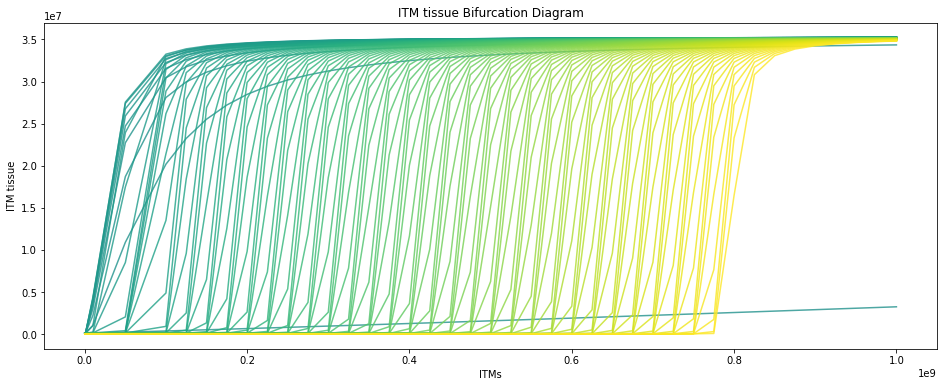

In [120]:
df = cells_dic['ITMtissue']

df.T.plot(
          figsize = (16,6), 
          legend = False, 
          colormap=ListedColormap(new_colors), 
          alpha = 0.8, 
          title = "ITM tissue Bifurcation Diagram")

plt.xlabel("ITMs");
plt.ylabel("ITM tissue");
plt.show()

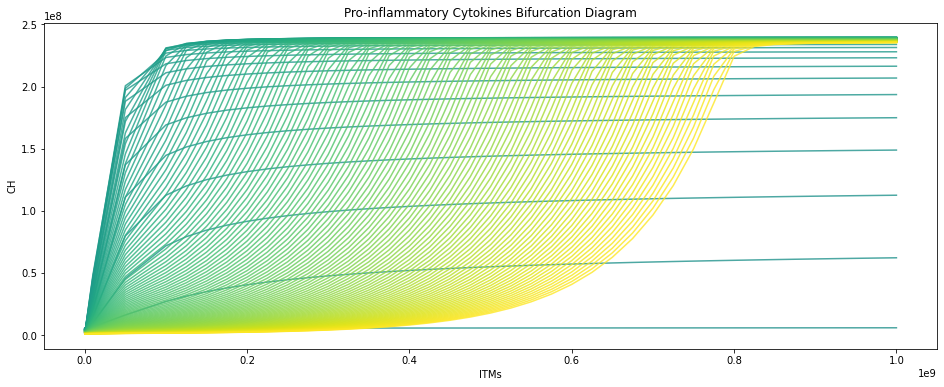

In [121]:
df = cells_dic['CH']
df.T.plot(figsize = (16,6),
#           marker='o',
#           markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Pro-inflammatory Cytokines Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("CH");
plt.show()

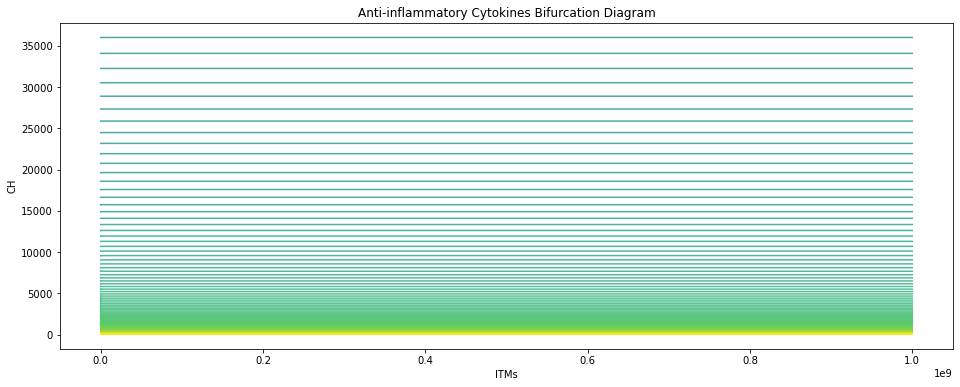

In [122]:
df = cells_dic['ACH']
df.T.plot(figsize = (16,6),
#           marker='o',
#           markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Anti-inflammatory Cytokines Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("CH");
plt.show()

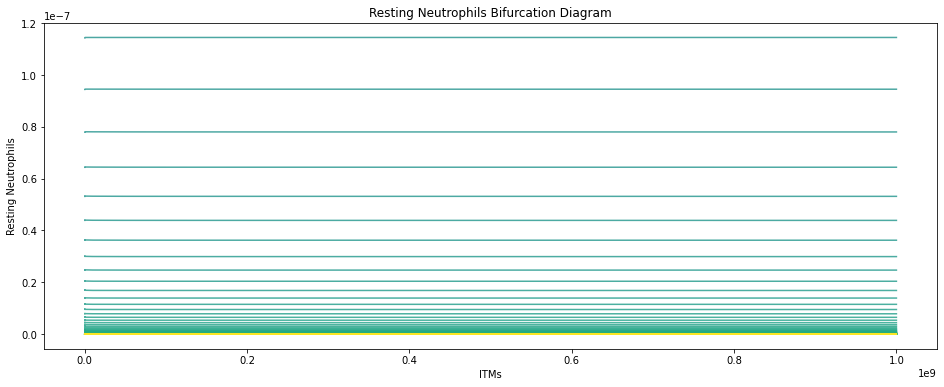

In [123]:
df = cells_dic['N_R']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Resting Neutrophils Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Resting Neutrophils");
plt.show()

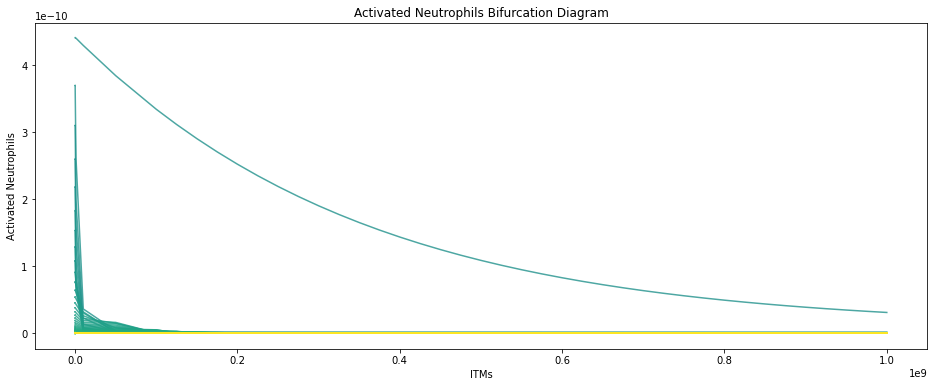

In [124]:
df = cells_dic['N_A']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Activated Neutrophils Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Activated Neutrophils");
plt.show()

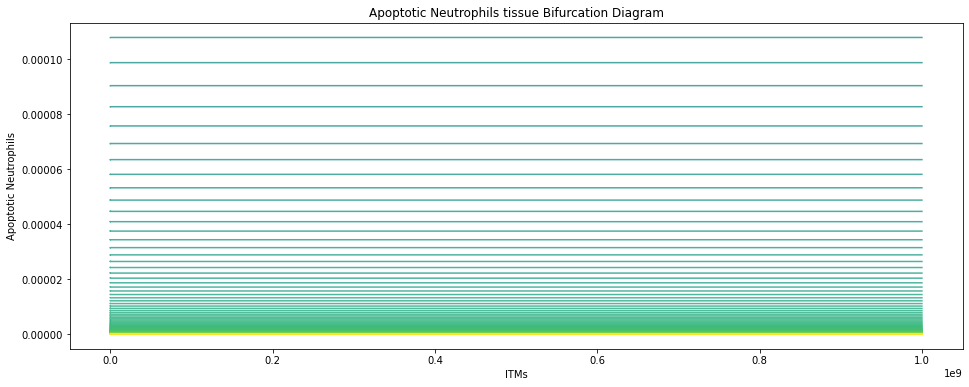

In [125]:
df = cells_dic['ND_A']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Apoptotic Neutrophils tissue Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Apoptotic Neutrophils");
plt.show()

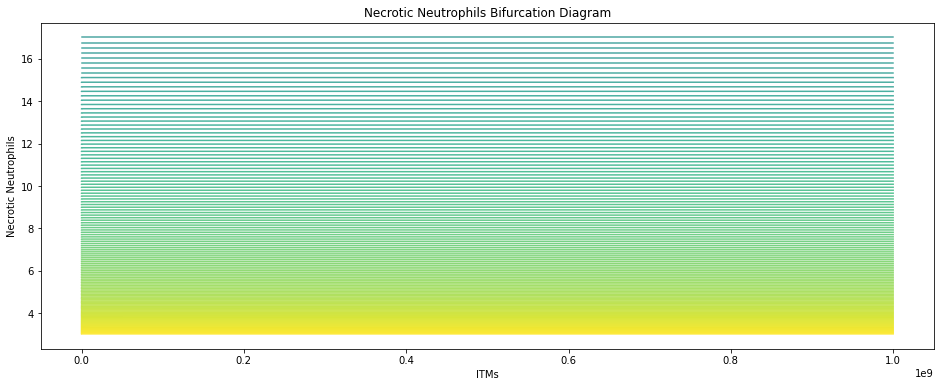

In [126]:
df = cells_dic['ND_N']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Necrotic Neutrophils Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Necrotic Neutrophils");
plt.show()

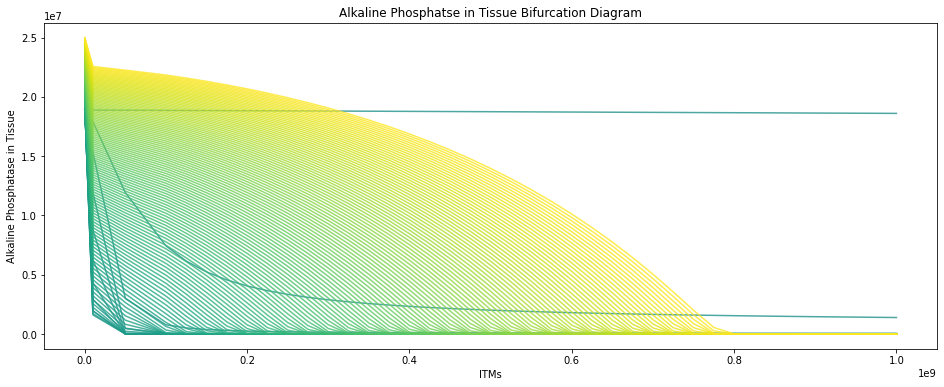

In [127]:
df = cells_dic['AP_Etissue']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',
          legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
          title = "Alkaline Phosphatse in Tissue Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Alkaline Phosphatase in Tissue"); 
plt.show()

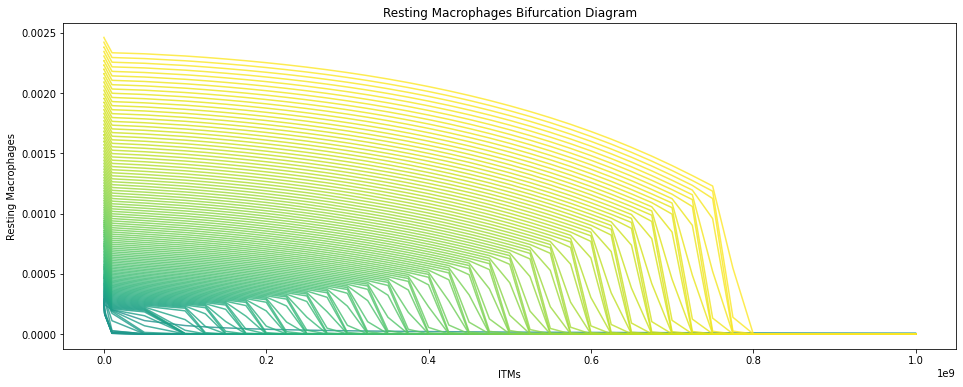

In [128]:
df = cells_dic['M_R']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Resting Macrophages Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Resting Macrophages");
plt.show()

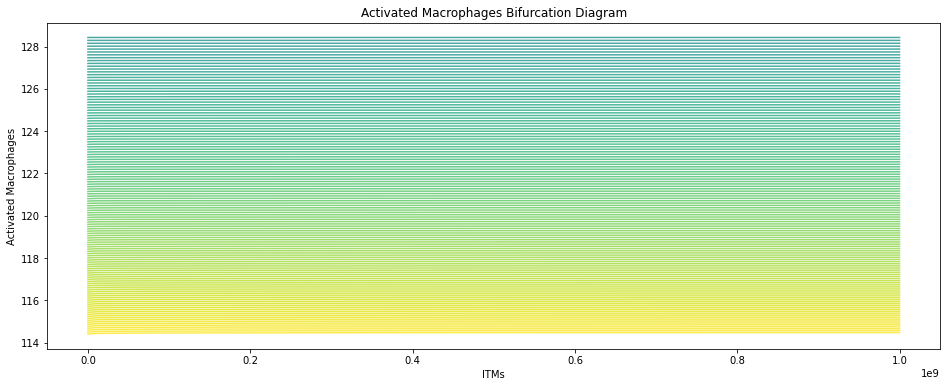

In [129]:
df = cells_dic['M_A']
df.T.plot(figsize = (16,6), 
#           marker='o',
          markerfacecolor = 'white',legend = False, colormap=ListedColormap(new_colors) , alpha = 0.8, 
                           title = "Activated Macrophages Bifurcation Diagram")
plt.xlabel("ITMs");
plt.ylabel("Activated Macrophages");
plt.show()